In [1]:
import numpy as np
import pandas as pd
from tsfresh import feature_extraction
import os
import seaborn as sns
import re
from collections import defaultdict

In [2]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

In [3]:
def normalize_signal(signal):
    """
    time_series
    
    Returns normalized TS: (TS - mean(TS))/std(TS)
    """
    std = np.std(signal)
    norm_signal = (signal - np.mean(signal)) / std if std else 1
    return norm_signal

In [4]:
def normalize_all_signals_in_ds(one_group_ds):
    for signal in one_group_ds.drop('t', axis=1):
        one_group_ds[signal] = normalize_signal(one_group_ds[signal])

In [5]:
# os.chdir('..')
os.getcwd()

'/home/poligon/master_degree'

In [6]:
# labels = pd.DataFrame(columns=['id', 'class', 'label'])
# labels.columns
# labels.append((pd.Series( [1, 2, 3], index=labels.columns)), ignore_index=True)
# # dfObj.append(pd.Series(['Raju', 21, 'Bangalore', 'India'], index=dfObj.columns ), ignore_index=True)

In [7]:
def append_signals_dataset(data_directory, signals_dataset = None, labels = None):
    data_dir_list = os.listdir(data_directory)
    os.chdir(data_directory)
    if labels is None:
        signal_id = 0
        labels = pd.DataFrame(columns=['id', 'class', 'label'])
    else:
        signal_id = labels.id.max() + 1
    for signal_label, directory in enumerate(data_dir_list):
        if os.path.isfile(directory) or directory[0] == '.':
                continue
        os.chdir(directory)
        for filename in os.listdir(os.curdir):
            if re.match(r'(.*csv)', filename):
                if (signals_dataset) is not None:
                    tmp_df = pd.read_csv(filename)
                    normalize_all_signals_in_ds(tmp_df)
                    tmp_df['id'] = signal_id
                    signals_dataset = signals_dataset.append(tmp_df, ignore_index=True)
                else:
                    signals_dataset = pd.read_csv(filename)
                    normalize_all_signals_in_ds(signals_dataset)
                    signals_dataset['id'] = signal_id
#                 print(signals_dataset.head(5))
                tmp_labels = pd.Series([signal_id, directory, np.int(signal_label)],
                                         index=labels.columns)
                labels = labels.append(tmp_labels, ignore_index=True)
                signal_id += 1
        os.chdir('../')
    os.chdir('../..')
    return signals_dataset, labels

Data preprocessing:
    - dropping U.1 == U
    - changing type
    - generating features

In [8]:
# os.chdir('../')
os.getcwd()

'/home/poligon/master_degree'

In [23]:
# Dataset for first gen
dataset, labels = append_signals_dataset('./data/gen_1_25')
dataset, labels = append_signals_dataset('./data/gen_3_25', dataset, labels)
# Dataset for second gen
dataset_2, labels_2 = append_signals_dataset('./data/gen_3_80')

In [24]:
def normalize_labels(labels_df):
    """
    Разметим все классы числами от 0 до количества классов
    и преобразуем новую колонку в формат чисел (float)
    """
    unique_classes = np.unique(labels_df['class'])
    labels_df['label'] = labels['class'].map(dict(zip(unique_classes, range(len(unique_classes)))))
    labels_df.label = labels.label.astype('int')

In [25]:
labels.shape

(65, 3)

In [26]:
print("Уникальные классы в датасете:", np.unique(labels['class']))
normalize_labels(labels)
normalize_labels(labels_2)
labels.sample(5)

Уникальные классы в датасете: ['le_8' 'more_8']


,id,class,label
38,38,more_8,1
39,39,more_8,1
20,20,le_8,0
3,3,more_8,1
31,31,le_8,0


In [34]:
dataset.head(20)

,t,Ug,Us,Pij,Pg,Pgt,delta,id
_temporary_index_column,,,,,,,,
0,0.01,1.116687,1.647838,-2.859261,-0.257116,1.0,-1.511526,0
1,0.02,1.116687,1.647838,-2.859261,-0.257116,1.0,-1.511526,0
2,0.03,1.116687,1.647838,-2.859261,-0.257116,1.0,-1.511526,0
3,0.04,1.116687,1.647838,-2.859261,-0.257116,1.0,-1.511526,0
4,0.05,1.116687,1.647838,-2.859261,-0.257116,1.0,-1.511526,0
5,0.06,1.116687,1.647838,-2.859261,-0.257116,1.0,-1.511526,0
6,0.07,1.116687,1.647838,-2.859261,-0.257116,1.0,-1.511526,0
7,0.08,1.116687,1.647838,-2.859261,-0.257116,1.0,-1.511526,0
8,0.09,1.116687,1.647838,-2.859261,-0.257116,1.0,-1.511526,0


In [35]:
# Удалим колонки которые не несут достаточной информации (повторяют значения, не изменяются)
# или могут быть некорректны
def drop_columns(dataset):
    mod_dataset = dataset.drop(['Us', 'Pgt', 'Pij'], axis=1)
    return mod_dataset
mod_dataset = drop_columns(dataset)
mod_dataset_2 = drop_columns(dataset_2)
# Проверим возможность склеить сигнал с метками
mod_dataset.head(5)

,t,Ug,Pg,delta,id
_temporary_index_column,,,,,
0,0.01,1.116687,-0.257116,-1.511526,0
1,0.02,1.116687,-0.257116,-1.511526,0
2,0.03,1.116687,-0.257116,-1.511526,0
3,0.04,1.116687,-0.257116,-1.511526,0
4,0.05,1.116687,-0.257116,-1.511526,0


In [32]:
features = defaultdict()
for param in mod_dataset.loc[:,'Ug':'delta']:
#     mod_dataset[param] = mod_dataset[param].astype('float')
    features[param] = feature_extraction.extract_features\
    (mod_dataset.loc[:,[param,'id','t']], column_sort='t', column_id='id')
    

Feature Extraction: 100%|██████████| 10/10 [00:28<00:00,  2.85s/it]


Извлечем те же признаки для проверочного датасета, который модель никогда не видела

In [33]:
features_val = defaultdict()
for param in mod_dataset_2.loc[:,'Ug':'delta']:
    features_val[param] = feature_extraction.extract_features\
    (mod_dataset_2.loc[:,[param,'id','t']], column_sort='t', column_id='id')

Feature Extraction: 100%|██████████| 9/9 [00:15<00:00,  1.72s/it]


### После обработки каждого сигнала библиотекой tsfresh извлекаем всевозможные признаки, признаки классифицированы по сигналу, из которого были получены (словарь features)
В конечном счете для каждого сигнала сформирован следующий набор данных:

In [36]:
for param in features:
    print("Для параметра", param, "получено", features[param].shape[1], "признака(ов).")

Для параметра Ug получено 756 признака(ов).
Для параметра Pg получено 756 признака(ов).
Для параметра delta получено 756 признака(ов).


In [56]:
# Пример хранящихся признаков
features['Ug']

variable,Ug__abs_energy,Ug__absolute_sum_of_changes,"Ug__agg_autocorrelation__f_agg_""mean""__maxlag_40","Ug__agg_autocorrelation__f_agg_""median""__maxlag_40","Ug__agg_autocorrelation__f_agg_""var""__maxlag_40","Ug__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","Ug__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","Ug__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","Ug__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","Ug__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,Ug__symmetry_looking__r_0.9,Ug__symmetry_looking__r_0.9500000000000001,Ug__time_reversal_asymmetry_statistic__lag_1,Ug__time_reversal_asymmetry_statistic__lag_2,Ug__time_reversal_asymmetry_statistic__lag_3,Ug__value_count__value_-1,Ug__value_count__value_0,Ug__value_count__value_1,Ug__variance,Ug__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
0,200.0,4.193479,0.859504,0.907176,0.018722,1.592504,-0.884128,-0.156445,0.019487,1.619349,...,1.0,1.0,-0.009735,-0.019772,-0.030139,0.0,0.0,0.0,1.0,0.0
1,200.0,3.987191,0.863016,0.908495,0.017426,1.628019,-0.906909,-0.160746,0.017602,1.644996,...,1.0,1.0,-0.010222,-0.020889,-0.032033,0.0,0.0,0.0,1.0,1.0
2,200.0,3.159681,0.839157,0.867914,0.015207,1.711693,-0.978199,-0.171906,0.008602,1.630660,...,1.0,1.0,-0.028362,-0.056951,-0.085767,0.0,0.0,0.0,1.0,0.0
3,200.0,3.735931,0.864389,0.907419,0.016397,1.655567,-0.927172,-0.164271,0.015645,1.662409,...,1.0,1.0,-0.011141,-0.022884,-0.035280,0.0,0.0,0.0,1.0,1.0
4,200.0,4.322899,0.857019,0.905694,0.019463,1.576482,-0.871448,-0.154393,0.020482,1.609345,...,1.0,1.0,-0.009580,-0.019411,-0.029522,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,200.0,3.569846,0.786377,0.798389,0.019136,1.681618,-0.982850,-0.167872,0.007424,1.453506,...,1.0,1.0,-0.058002,-0.113351,-0.165352,0.0,0.0,0.0,1.0,0.0
61,200.0,3.344199,0.822504,0.842017,0.016757,1.736013,-0.990607,-0.173829,0.005656,1.578476,...,1.0,1.0,-0.031586,-0.063123,-0.094609,0.0,0.0,0.0,1.0,0.0
62,200.0,3.272611,0.831384,0.853030,0.016383,1.748300,-0.990010,-0.175168,0.005880,1.612456,...,1.0,1.0,-0.025188,-0.050879,-0.077078,0.0,0.0,0.0,1.0,1.0


## Поиск наиболее важных признаков, которые позволят предсказывать результат переходного процесса

In [47]:
# Удаляем фичи количество признаков в которых меньше количества классов
def clear_useless_features(features, threshold=2):
    for feature in features.columns:
        if features[feature].nunique() <= threshold \
            or features[feature].isna().sum():
            features = features.drop(feature, axis=1)
    return features

In [48]:
modified_features = defaultdict()
for param in features:
    modified_features[param] = clear_useless_features(features[param],
                                                     labels.label.nunique())
    print(f"Число удаленных признаков для {param}:",
          features[param].shape[1] - modified_features[param].shape[1])

Число удаленных признаков для Ug: 71
Число удаленных признаков для Pg: 65
Число удаленных признаков для delta: 70


Поиск признаков, имеющих наибольшую корреляцию с целевой переменной sklearn (Только для регресии и неотрицательных признаков)

In [49]:
def delete_negative_features(X):
    for i in X.columns:
        if X[i].min() < 0:
            X = X.drop(i, axis=1)
    return X

In [50]:
# X = delete_negative_features(modified_features['U'])
# X_2 = 
y = labels.label
# bestfeatures = SelectKBest(score_func=chi2, k=10)
# fit = bestfeatures.fit(X, labels.label)
# dfscores = pd.DataFrame(fit.scores_)
# dfcolumns = pd.DataFrame(X.columns)
# featureScores = pd.concat([dfcolumns,dfscores],axis=1)
# featureScores.columns = ['Specs','Score']  #naming the dataframe columns
# print(featureScores.nlargest(10,'Score'))

Использование дерева для поиска фич

In [51]:
def plot_features(X, y):
#     X = modified_features['U']
#     y = labels.label
    model = ExtraTreesClassifier(n_estimators=200)
    model.fit(X,y)
#     print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
    #plot graph of feature importances for better visualization
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(15).plot(kind='barh')
    plt.show()
    return feat_importances.nlargest(15)

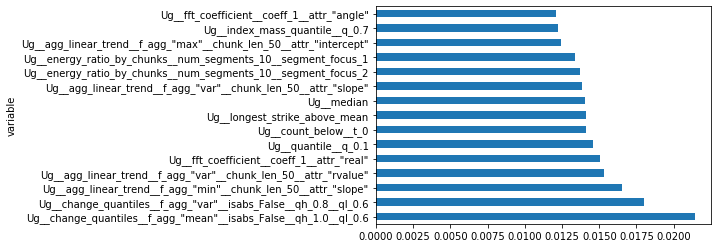

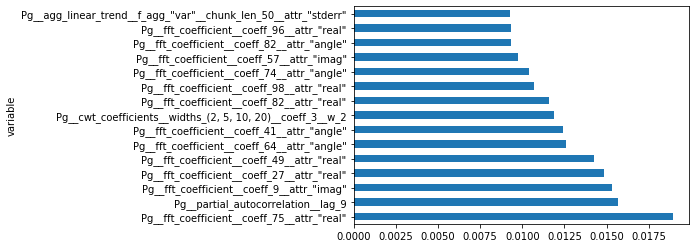

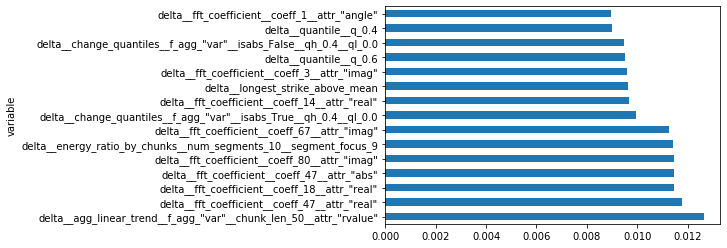

In [52]:
most_valuable_feat = dict([[feat, None] for feat in features])
for param in features:
    most_valuable_feat[param] = (plot_features(modified_features[param].astype('float32'), labels.label))

In [57]:
# Создаем датафрэйм с индексами, который будем доплнять самыми релевантными фичами
def remain_relevant_features(features):
    resulted_df = pd.DataFrame(index=features['Ug'].index)
    # Дополняем датафрэйм
    for param in features:
        for feat in features[param]:
            if feat in most_valuable_feat[param]:
                if most_valuable_feat[param][feat] >= 0.014:
                    resulted_df = resulted_df.join(features[param][feat])
    return resulted_df

In [59]:
# Выведем первые две строки получившегося датафрэйма
resulted_df = remain_relevant_features(features)
resulted_df.head(2)

,"Ug__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""slope""","Ug__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""rvalue""","Ug__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.6","Ug__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.6",Ug__count_below__t_0,"Ug__fft_coefficient__coeff_1__attr_""real""",Ug__longest_strike_above_mean,Ug__median,Ug__quantile__q_0.1,"Pg__fft_coefficient__coeff_27__attr_""real""","Pg__fft_coefficient__coeff_49__attr_""real""","Pg__fft_coefficient__coeff_75__attr_""real""","Pg__fft_coefficient__coeff_9__attr_""imag""",Pg__partial_autocorrelation__lag_9
id,,,,,,,,,,,,,,
0,-0.777599,-0.062383,-0.010195,0.000259,0.56,38.977855,88.0,-0.322796,-1.160566,-0.326442,-0.600430,-0.707186,5.550073,-0.04674
1,-0.780215,-0.139870,-0.009811,0.000239,0.55,32.632124,90.0,-0.319320,-1.146038,-0.378597,-0.664108,-0.773791,6.031831,-0.04307


In [61]:
print("Оставшиеся фичи:")
print(*resulted_df.columns, sep='\n')

Оставшиеся фичи:
Ug__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"
Ug__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"
Ug__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6
Ug__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6
Ug__count_below__t_0
Ug__fft_coefficient__coeff_1__attr_"real"
Ug__longest_strike_above_mean
Ug__median
Ug__quantile__q_0.1
Pg__fft_coefficient__coeff_27__attr_"real"
Pg__fft_coefficient__coeff_49__attr_"real"
Pg__fft_coefficient__coeff_75__attr_"real"
Pg__fft_coefficient__coeff_9__attr_"imag"
Pg__partial_autocorrelation__lag_9


Построим тепловую карту фич, взятых из предыдущего шага

In [62]:
# data = features['U'].iloc[:,0:50].join(labels.loc[:,['label']], on='id')

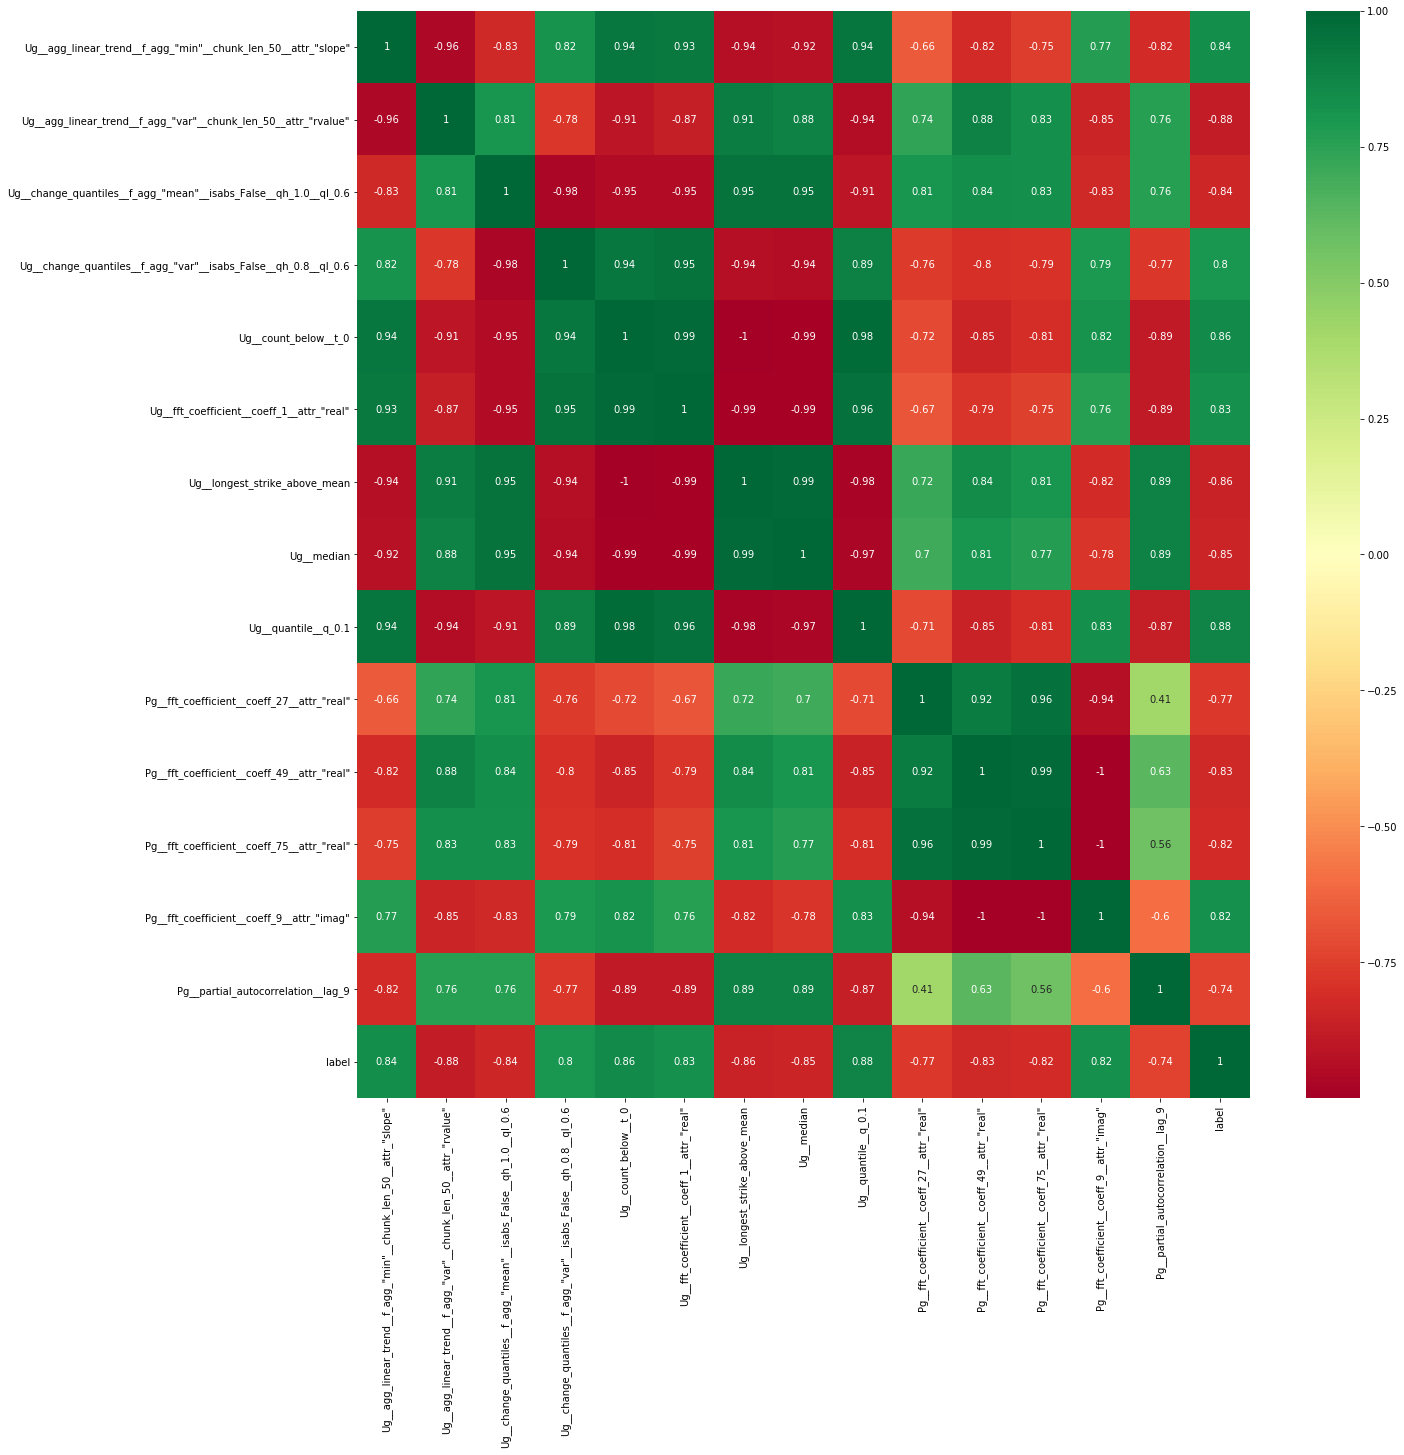

In [63]:
## get correlations of each features in dataset
data = resulted_df.join(labels.loc[:,['id', 'label']])
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Постоение простейших моделей, градиентный бустинг и ансамбль решающих деревьев

In [64]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [65]:
X_train, X_test, y_train, y_test = train_test_split(resulted_df, labels.label, test_size=0.2, random_state=42)

### Ансамбль решающих деревьев

In [66]:
clf = RandomForestClassifier(n_estimators=200, max_depth=5, max_features=0.7)
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')
scores

array([1.        , 0.85714286, 1.        , 0.90909091, 1.        ])

In [67]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=0.7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [68]:
y_pred = clf.predict_proba(X_test)
y_scores = y_pred[:,1]
y_scores

array([0.005, 0.235, 1.   , 0.64 , 1.   , 0.09 , 1.   , 1.   , 0.235,
       0.   , 0.   , 0.93 , 1.   ])

In [69]:
y_true = np.array(y_test)
metrics.roc_auc_score(y_true, y_scores)

1.0

## Проверка на другом генераторе, который модель никогда ранее не видела

In [70]:
resulted_df_val = remain_relevant_features(features_val)
labels_2.label = pd.to_numeric(labels_2.label)
X_val, y_val = resulted_df_val, labels_2.label
y_pred = clf.predict_proba(X_val)
y_scores = y_pred[:,1]
y_predicted_class = clf.predict(X_val)
print(y_scores)
y_predicted_class

[0.84  0.84  0.555 0.79  0.515 0.51  0.84  0.625 0.55  0.625 0.625 0.82
 0.55  0.83  0.84  0.575 0.525 0.625 0.21  0.32  0.365 0.    0.37  0.335
 0.    0.33  0.33  0.24  0.015 0.625 0.215 0.55  0.395 0.    0.32  0.325]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0])

In [71]:
y_true = np.array(y_val)
y_true

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [73]:
print("ROC AUC score:", metrics.roc_auc_score(y_true, y_scores))
print("F1 score:", metrics.f1_score(y_true, y_predicted_class))
print("Accuracy:", metrics.accuracy_score(y_true, y_predicted_class))

ROC AUC score: 0.8921875000000001
F1 score: 0.9
Accuracy: 0.8888888888888888


### Градиентный бустинг

In [89]:
clf = GradientBoostingClassifier(learning_rate=0.05, random_state=42, n_estimators=60, max_depth=5)
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')
scores

array([1.        , 0.85714286, 1.        , 0.90909091, 1.        ])

In [90]:
clf.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=60,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [91]:
y_pred = clf.predict_proba(X_test)
y_scores = y_pred[:,1]
y_scores

array([0.02721432, 0.02721432, 0.97829055, 0.97829055, 0.97829055,
       0.02721432, 0.97829055, 0.97829055, 0.02721432, 0.02721432,
       0.02721432, 0.97829055, 0.97829055])

In [92]:
y_true = np.array(y_test)
metrics.roc_auc_score(y_true, y_scores)

1.0

## Проверка градиентного бустинга

In [93]:
resulted_df_val = remain_relevant_features(features_val)
labels_2.label = pd.to_numeric(labels_2.label)
X_val, y_val = resulted_df_val, labels_2.label
y_pred = clf.predict_proba(X_val)
y_scores = y_pred[:,1]
y_predicted_class = clf.predict(X_val)
y_scores

array([0.97829055, 0.97829055, 0.97829055, 0.97829055, 0.97829055,
       0.97829055, 0.97829055, 0.97829055, 0.97829055, 0.97829055,
       0.97829055, 0.97829055, 0.97829055, 0.97829055, 0.97829055,
       0.97829055, 0.97829055, 0.97829055, 0.97829055, 0.97829055,
       0.97829055, 0.02721432, 0.97829055, 0.97829055, 0.02721432,
       0.97829055, 0.97829055, 0.97829055, 0.02721432, 0.97829055,
       0.97829055, 0.97829055, 0.97829055, 0.02721432, 0.97829055,
       0.97829055])

In [94]:
y_true = np.array(y_val)
y_true

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [95]:
print("ROC AUC score:", metrics.roc_auc_score(y_true, y_scores))
print("F1 score:", metrics.f1_score(y_true, y_predicted_class))
print("Accuracy:", metrics.accuracy_score(y_true, y_predicted_class)) 

ROC AUC score: 0.625
F1 score: 0.7692307692307693
Accuracy: 0.6666666666666666


Гит комит

In [81]:
!git status
!git add .
!git commit -m "Added another generator"


On branch master
Your branch is ahead of 'origin/master' by 1 commit.
  (use "git push" to publish your local commits)

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)
  (commit or discard the untracked or modified content in submodules)

	modified:   Data_forming.ipynb
	modified:   Data_processing.ipynb
	modified:   data/gen_1_25/le_8/1.csv
	modified:   data/gen_1_25/le_8/10.csv
	modified:   data/gen_1_25/le_8/11.csv
	modified:   data/gen_1_25/le_8/12.csv
	modified:   data/gen_1_25/le_8/13.csv
	modified:   data/gen_1_25/le_8/14.csv
	modified:   data/gen_1_25/le_8/15.csv
	modified:   data/gen_1_25/le_8/16.csv
	modified:   data/gen_1_25/le_8/17.csv
	modified:   data/gen_1_25/le_8/2.csv
	modified:   data/gen_1_25/le_8/3.csv
	modified:   data/gen_1_25/le_8/4.csv
	modified:   data/gen_1_25/le_8/5.csv
	modified:   data/gen_1_25/le_8/6.csv
	modified:   data/gen_1_25/le_8

The file will have its original line endings in your working directory.
The file will have its original line endings in your working directory.
[master 2dd83fa] Added another generator
 170 files changed, 1994 insertions(+), 911 deletions(-)
 rewrite Data_forming.ipynb (88%)
 rename data/gen_3_25/{descr.inf.txt => descr.inf} (100%)
 rename data/gen_3_80/{descr.inf.txt => descr.inf} (100%)
